# **Vector Autoregressive - Reservoir Levels**


---



## **Libraries**

In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.model_selection import train_test_split
from numpy import array

plt.rcParams['figure.figsize'] = (18,10)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from keras.preprocessing.sequence import TimeseriesGenerator

## **Load Data**

The data was obtained from 2 sources:
1.   Watercare Services Limited
2.   NIWA

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_UN= pd.read_csv('gdrive/My Drive/DL Project/Upper Niho/Upper_Niho_Clean.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_M= pd.read_csv('gdrive/My Drive/DL Project/Mangatangi/Mangatangi_All.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_W= pd.read_csv('gdrive/My Drive/DL Project/Waitakere/Waitakere_Clean.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True

In [ ]:
df_input = df_UN
df = df_M

if df_input is df_UN:
  site = 'Upper Nihotupu'
elif df_input is df_M:
  site = 'Mangatangi'
elif df_input is df_W:
  site = 'Waitakere'

In [ ]:
site

'Mangatangi'

In [ ]:
#df.drop(['Rainfall (NiWa)', 'Spill'], axis=1, inplace=True)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sn
from statsmodels.tsa.api import VAR

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Statistical Tests

### AD Fuller

In [ ]:
for i in range(len(df.columns)):
  result = adfuller(df[df.columns[i]])

  if result[1] > 0.05:
    print(f'{df.columns[i]}. Series is not Stationary. Result: {result[1]}')
  else:
    print(f'{df.columns[i]}. Series is Stationary. Result: {result[1]}')

Level. Series is Stationary. Result: 0.010597035927296598
Spill. Series is Stationary. Result: 1.4080477956614307e-26
Rainfall (WSL). Series is Stationary. Result: 0.0
Abstraction. Series is Stationary. Result: 2.158828567830968e-06
Compensation. Series is Stationary. Result: 0.00016852470808019113
Rainfall (NIWA). Series is Stationary. Result: 4.596321752713017e-22
Soil Moisture. Series is Stationary. Result: 0.00017873629694100307
Max Temp. Series is Stationary. Result: 0.00035850463289247546
Penman Evaporation. Series is Stationary. Result: 0.00011735465968068985
Vapour Pressure. Series is Stationary. Result: 9.192063660910322e-06
Solar Radiation. Series is Stationary. Result: 0.0007031184711666215
Year sin. Series is Stationary. Result: 0.0
Year cos. Series is Stationary. Result: 2.9825218060261495e-24


In [ ]:
max_lags = 7
y = 'Level'

### Granger Causality:

H0: X does not granger cause Y (accept/fail to reject null hypothesis - P >=0.05

H1: X granger causes Y (reject the null hypothesis) - P <=0.05

In [ ]:
for i in range(len(df.columns)-1):
  results = grangercausalitytests(df[[y,df.columns[i+1]]], max_lags, verbose=False)
  p_values = [round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
  print(f'Column: {df.columns[i+1]}, P-Values: {p_values}')

Column: Spill, P-Values: [0.2063, 0.002, 0.0014, 0.0058, 0.0121, 0.027, 0.034]
Column: Rainfall (NiWa), P-Values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column: Rainfall (WSL), P-Values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column: Vapour Pressure (hPa), P-Values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column: Observed Penman Evaporation, P-Values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column: Abstraction (m3), P-Values: [0.0, 0.0236, 0.0031, 0.0061, 0.0129, 0.0275, 0.0513]
Column: Compensation (m3), P-Values: [0.0001, 0.0214, 0.0001, 0.0015, 0.0036, 0.0117, 0.0246]
Column: Max Temp, P-Values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column: Soil Moisture, P-Values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column: Solar Radiation, P-Values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column: Year sin, P-Values: [0.3415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001]
Column: Year cos, P-Values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001]


## Order Selection

In [ ]:
#step = int(0.85*(len(df_input)))+360
step_pre = int((len(df_input)))-365

In [ ]:
df_train_pre = df_input[:step_pre]
df_test_pre = df_input[step_pre:]

In [ ]:
model_pre = VAR(df_train_pre, freq='D')
for i in range(30):
  results = model_pre.fit(i+1)
  print('Order = ', i+1)
  print('AIC: ', results.aic)
  print('BIC: ', results.bic)


In [ ]:
model_pre.select_order(10).summary()

,AIC,BIC,FPE,HQIC
0,55.39,55.41,1.136e+24,55.40
1,2.245,2.526,9.443,2.345
2,0.8200,1.362*,2.270,1.012
3,0.6223,1.426,1.863,0.9067*
4,0.5766,1.641,1.780,0.9534
5,0.5501,1.875,1.733,1.019
6,0.5478*,2.134,1.730*,1.109
7,0.5516,2.399,1.736,1.206
8,0.5515,2.660,1.736,1.298
9,0.5534,2.923,1.740,1.392


## VAR FUNC

In [ ]:
timestep = 7
var_order = 2

In [ ]:
actual = pd.DataFrame()
pred_d_ = []
#step_ = 1
testing_ = pd.DataFrame()


step = (int((len(df_input)))-365)


for i in range(0,365):
  step = step+1
  df_train = df_input[:step]
  df_test = df_input[step+(timestep-1):]

  model = VAR(df_train, freq='D')
  results = model.fit(var_order)
  lag = results.k_ar
  pred = results.forecast(df_train.values[-lag:], steps=timestep)
  pred_d = pd.DataFrame(pred, columns = ['Level Pred','Column_B','Column_C','Column_A','Column_B','Column_C', 'Column_A','Column_B','Column_C', 'Column_A','Column_B','Column_C', 'Col']) #
  pred_d.drop(['Column_B','Column_C','Column_A','Column_B','Column_C', 'Column_A','Column_B','Column_C', 'Column_A','Column_B','Column_C', 'Col'], axis=1, inplace=True) #

  pred_d_.append(pred_d['Level Pred'])
  _actual = df_test['Level']#[:timestep]
  #_actual = _actual.values
  try:
    actual['actual'] = _actual.values
    #predictions['pred'] = pred_d
  except ValueError:
    pass  # do nothing!



In [ ]:
pred_test = np.array(pred_d_)

In [ ]:
pred_test = pred_test.T

In [ ]:
pred_test = pd.DataFrame(pred_test)

In [ ]:
if timestep == 7:
  pred_test_ = pred_test.drop([0, 1, 2, 3, 4, 5])
elif timestep == 30:
  pred_test_ = pred_test.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [ ]:
pred_test_ = pred_test_.T

In [ ]:
actual['pred'] = pred_test_[:-(365-len(actual))].values

## **Fixed Partitioning**

In [ ]:
df_train_plot = df_input['Level']
df_test_plot = df_input['Level']
df_orig_plot = df_input['Level']

In [ ]:
plot_step = (int((len(df_input)))-365)

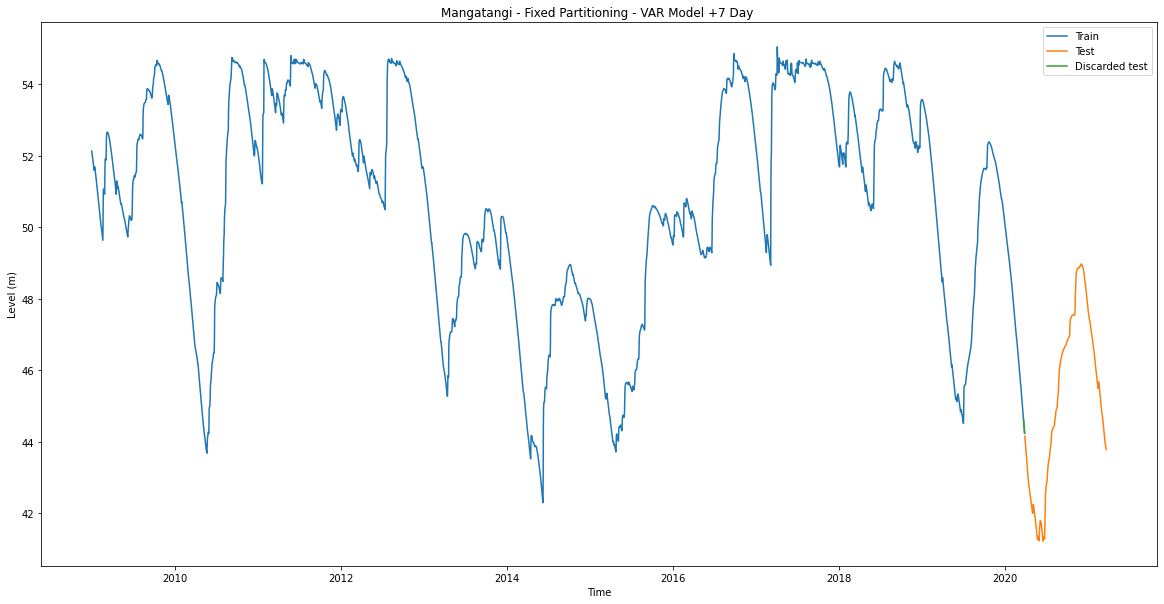

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df_train_plot[:plot_step+(timestep-1)].index, df_train_plot[:plot_step+(timestep-1)], label = 'Train')
#plt.plot(df_test_plot[plot_step:].index, df_test_plot[plot_step:], label = 'Test')
plt.plot(df_test_plot[plot_step+(timestep-1):].index, df_test_plot[plot_step+(timestep-1):], label = 'Test')
#plt.plot(test_final.index, test_final,  label = 'Test')
plt.plot(df_orig_plot[plot_step:plot_step+(timestep-1)].index, df_orig_plot[plot_step:plot_step+(timestep-1)],  label = 'Discarded test')
plt.legend(loc = 'best')
plt.title(f'{site} - Fixed Partitioning - VAR Model +{timestep} Day ')
plt.xlabel("Time")
plt.ylabel("Level (m)")

plt.show()

In [ ]:
print(f'{site} Train: {len(df_train_plot[:plot_step+(timestep-1)])}')
print(f'{site} Test: {len(df_test_plot[plot_step+(timestep-1):])}')
print(f'{site} Discarded Test: {len(df_orig_plot[plot_step:plot_step+(timestep-1)])}')

Mangatangi Train: 4105
Mangatangi Test: 359
Mangatangi Discarded Test: 6


In [ ]:
#actual.to_csv('actual_df.csv')

## Creating Date Object

In [ ]:
df_date = pd.DataFrame(df_input[-len(actual):])
#df_date =df_date.reset_index
df_date.reset_index(inplace=True)

In [ ]:
df_date_ = df_date['Date']

In [ ]:
actual = actual.join(df_date_)

In [ ]:
#actual['Date'] = pd.date_range(start='2020-04-04', periods=len(actual), freq='D')
actual = actual.set_index('Date')

In [ ]:
actual

,actual,pred
Date,,
2020-03-30,44.077,44.309785
2020-03-31,43.999,44.181497
2020-04-01,43.925,44.123607
2020-04-02,43.844,44.029000
2020-04-03,43.759,43.919687
...,...,...
2021-03-18,43.938,44.099895
2021-03-19,43.887,44.068173
2021-03-20,43.851,44.060521


# Results

Text(0.5, 1.0, 'Mangatangi - +7day Forecast. VAR(2)')

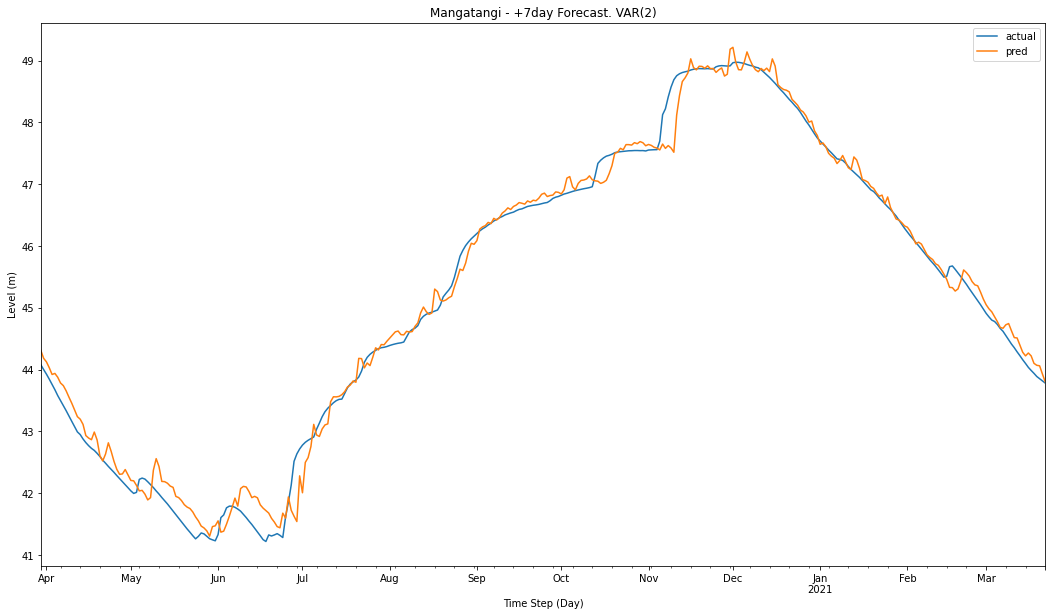

In [ ]:
actual.plot(y=['actual','pred'])
plt.legend(loc = 'best')
plt.xlabel("Time Step (Day)")
plt.ylabel("Level (m)")
plt.title(f'{site} - +{timestep}day Forecast. VAR({var_order})')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
#rmse30 = math.sqrt(mean_squared_error(actual['actual'], actual['pred']))

In [ ]:
if timestep == 7:
  #pred7 = actual[::6]
  rmse7 = math.sqrt(mean_squared_error(actual['actual'], actual['pred']))
  mae7 = mean_absolute_error(actual['actual'], actual['pred'])
  print (f'VAR({var_order}) RMSE +7: {rmse7}')
  print (f'VAR({var_order}) MAE +7: {mae7}')
elif timestep == 30:
  #pred30 = actual[::29]
  rmse30 = math.sqrt(mean_squared_error(actual['actual'], actual['pred']))
  mae30 = mean_absolute_error(actual['actual'], actual['pred'])
  print (f'VAR({var_order}) RMSE +30: {rmse30}')
  print (f'VAR({var_order}) MAE +30: {mae30}')

VAR(2) RMSE +7: 0.23261185779617927
VAR(2) MAE +7: 0.16468822889235982


## Error

In [ ]:
actual['year'] = actual.index.year
actual['month'] = actual.index.month

In [ ]:
month_n = 12
df_month = actual.groupby('month')

In [ ]:
error_df = pd.DataFrame()
rmse_list = []
mse_list = []
mae_list = []
for i in range(1,13):
  rmse_month = math.sqrt(mean_squared_error(df_month.get_group(i)['actual'], df_month.get_group(i)['pred']))
  #mse_month = mean_squared_error(df_month.get_group(i)['Level'], df_month.get_group(i)['pred'])
  mae_month = mean_absolute_error(df_month.get_group(i)['actual'], df_month.get_group(i)['pred'])

  rmse_list.append(rmse_month)
  #mse_list.append(mse_month)
  mae_list.append(mae_month)
  error_df = pd.DataFrame(rmse_list, columns=['RMSE'])
  #error_df['MSE'] = mse_list
  error_df['MAE'] = mae_list

In [ ]:
error_df.set_index([['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']], inplace=True)

Text(0.5, 1.0, 'Mangatangi - +7 Day Forecast Error Monthly VAR(2)')

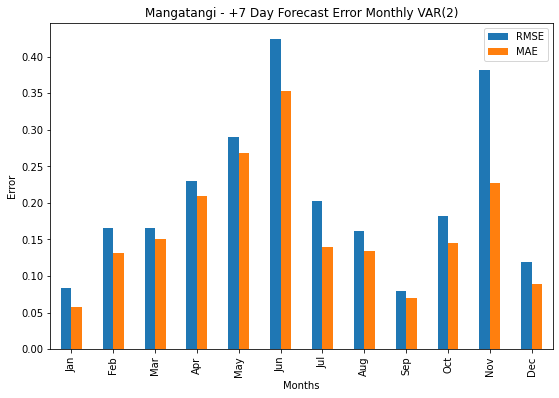

In [ ]:
# Plot a bar chart using the DF
ax_errors = error_df.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig_errors = ax_errors.get_figure()
# Change the plot dimensions (width, height)
fig_errors.set_size_inches(9, 6)
# Change the axes labels
ax_errors.set_xlabel("Months")
ax_errors.set_ylabel("Error")
plt.title(f'{site} - +{timestep} Day Forecast Error Monthly VAR({var_order})')

# **Testing Ground**

In [ ]:
(int((len(df_input)))-365)

4099

In [ ]:
actual_test = pd.DataFrame()

In [ ]:
step_test = (int((len(df_input)))-365)


for i in range(0,365):
  step_test = step_test+1
  df_train_test = df_input[:step_test]
  df_test_test = df_input[step_test+30-1:]
  print (df_train_test)
  print (df_test_test)

  _actual_test = df_test_test['Level'[:30]]
  #_actual = _actual.values
  try:
    actual_test['actual'] = _actual_test.values
    actual_test['act2'] = df_test_test.values
    #predictions['pred'] = pred_d
  except ValueError:
    pass  # do nothing!

Streaming output truncated to the last 5000 lines.
2020-11-01  47.552    0.0            1.02  ...             24.4   -0.8517    0.5241
2020-11-02  47.555    0.0            0.00  ...             14.5   -0.8425    0.5387
2020-11-03  47.557    0.0            1.02  ...             11.2   -0.8331    0.5531

[4325 rows x 13 columns]
             Level  Spill  Rainfall (WSL)  ...  Solar Radiation  Year sin  Year cos
Date                                       ...                                     
2020-12-03  48.971    0.0            1.41  ...             27.4   -0.4517    0.8922
2020-12-04  48.963    0.0            0.00  ...             13.9   -0.4363    0.8998
2020-12-05  48.952    0.0            0.00  ...             28.6   -0.4207    0.9072
2020-12-06  48.936    0.0            0.00  ...             21.9   -0.4051    0.9143
2020-12-07  48.922    0.0            0.46  ...             16.9   -0.3893    0.9211
...            ...    ...             ...  ...              ...       ...       ...

In [ ]:
actual_test

,actual
0,42.484
1,42.432
2,42.384
3,42.336
4,42.284
...,...
330,43.938
331,43.887
332,43.851
333,43.815
